In [2]:
import cv2
import pandas as pd
from ultralytics import YOLO
import json

# Initialize the YOLO model
model = YOLO('yolov10m.pt')

# Load the class names
class_list = model.names


In [2]:
print(class_list)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [9]:
import cv2
import pandas as pd
from ultralytics import YOLO
import json

# Initialize the YOLO model
model = YOLO('yolov10m.pt')

# Load the class names
class_list = model.names

# Open the video file
cap = cv2.VideoCapture('testvideo.mp4')

# Initialize video writer for saving the output video
output_video_path = 'output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for the output video
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)  # Get the video's FPS
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Initialize variables for tracking
tracking_timestamps = {}
disappearance_counts = {}
debounce_limit = 10  # Frames for debouncing
max_disappearance_time = debounce_limit / fps  # Max time in seconds to debounce
frame_buffer = {}  # To hold the last known frame for each object

# New JSON structure
tracking_data_json = []

frame_number = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_number += 1
    timestamp = frame_number / fps  # Calculate the timestamp for each frame

    # Perform model prediction on the current frame
    results = model.predict(frame)

    # Check if the results contain any detection data
    if not results or results[0].boxes is None:
        continue  # Skip if there are no detection results

    # Extract the bounding box data
    a = results[0].boxes.data.detach().cpu().numpy()  # Convert to numpy array
    px = pd.DataFrame(a)

    # List to keep track of IDs detected in this frame
    detected_ids = []

    # Iterate over each detection in the frame
    for index, row in px.iterrows():
        x1, y1, x2, y2, conf, d = row

        # Only consider detections with confidence > 0.5
        if conf > 0.5 and int(d) < len(class_list):
            c = class_list[int(d)]  # Get the class name
            id = int(index)  # Assign a unique ID for the object

            detected_ids.append(id)

            # Check if the object is being detected after disappearing for a while
            if id not in tracking_timestamps:
                # If this is the first detection of this object or it's been missing, reset start_time
                tracking_timestamps[id] = {
                    "class": c,
                    "start_time": timestamp,
                    "last_time": timestamp
                }
                disappearance_counts[id] = 0  # Reset disappearance count
            else:
                # Update the last detection time
                tracking_timestamps[id]['last_time'] = timestamp
                disappearance_counts[id] = 0  # Reset disappearance count

            # Update the frame buffer (store the most recent frame where the object was seen)
            frame_buffer[id] = (int(x1), int(y1), int(x2), int(y2))

            # Draw bounding box and label on the frame
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(frame, c, (int(x1), int(y1) + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Process the objects that were detected in previous frames but not in the current frame
    for id in list(tracking_timestamps.keys()):
        if id not in detected_ids:
            # If the object is not detected, increment the disappearance count
            disappearance_counts[id] += 1

            # If the object has been missing for fewer than debounce_limit frames, don't finalize yet
            if disappearance_counts[id] <= debounce_limit:
                # Use the last known bounding box from the frame buffer
                x1, y1, x2, y2 = frame_buffer[id]
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)  # Yellow box for missing object
                cv2.putText(frame, tracking_timestamps[id]['class'], (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
            else:
                # Once the debounce limit is exceeded, finalize the track and remove the object
                tracking_data_json.append({
                    "name": tracking_timestamps[id]['class'],
                    "trackId": id,
                    "startTime": f"{tracking_timestamps[id]['start_time']:.2f}s",
                    "endTime": f"{tracking_timestamps[id]['last_time']:.2f}s"
                })
                # Remove the object from tracking
                del tracking_timestamps[id]
                del disappearance_counts[id]
                del frame_buffer[id]

    # Write the frame to the output video
    out.write(frame)

    # Optionally, show the frame in real-time (commented out)
    # cv2.imshow("frames", frame)
    # if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
    #     break

# Release video capture and writer resources
cap.release()
out.release()
cv2.destroyAllWindows()

# Save the simplified JSON output to a file (automatically overwrites)
with open('tracking_data_output.json', 'w') as f:
    json.dump(tracking_data_json, f, indent=4)

print("Tracking data has been saved to 'tracking_data_output.json'")
print(f"Output video saved as '{output_video_path}'")



0: 384x640 (no detections), 24.3ms
Speed: 5.1ms preprocess, 24.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 15.7ms
Speed: 1.0ms preprocess, 15.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 16.5ms
Speed: 2.2ms preprocess, 16.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 28.1ms
Speed: 2.0ms preprocess, 28.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 17.0ms
Speed: 2.0ms preprocess, 17.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 15.0ms
Speed: 2.1ms preprocess, 15.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 15.9ms
Speed: 2.1ms preprocess, 15.9ms i

C:\Users\singh\AppData\Local\Temp\ipykernel_15080\283500956.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_objects)  # Use the 'tab20' colormap


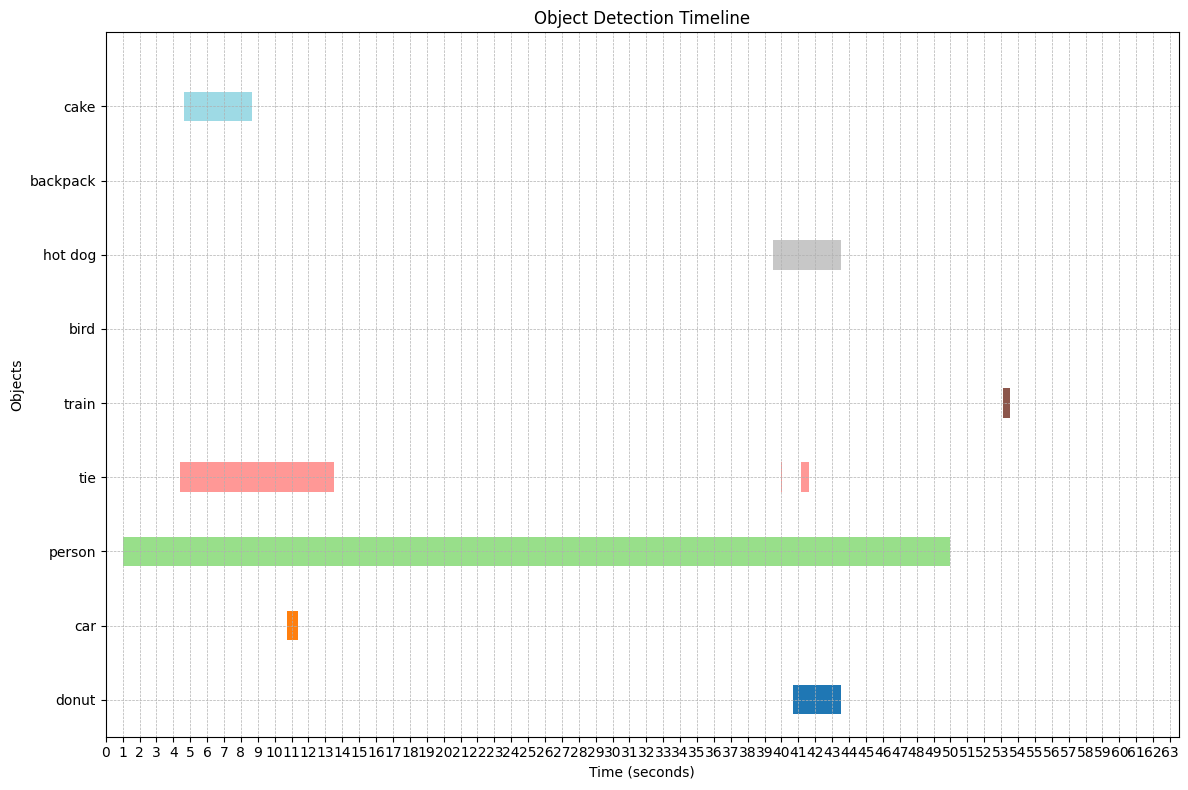

In [10]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON file
with open('tracking_data_output.json', 'r') as f:
    tracking_data = json.load(f)

# Extract unique objects (names)
unique_objects = list(set([item['name'] for item in tracking_data]))

# Prepare data for plotting
object_intervals = []
object_names = []
for obj in tracking_data:
    start_time = float(obj['startTime'][:-1])  # Remove 's' and convert to float
    end_time = float(obj['endTime'][:-1])      # Remove 's' and convert to float
    object_intervals.append((start_time, end_time))
    object_names.append(obj['name'])

# Map object names to unique indices (for plotting purposes)
name_to_idx = {name: idx for idx, name in enumerate(unique_objects)}

# Set a unique color for each object
num_objects = len(unique_objects)
colors = plt.cm.get_cmap('tab20', num_objects)  # Use the 'tab20' colormap

# Create a plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each object's timeline as a horizontal bar with different colors
for i, (start, end) in enumerate(object_intervals):
    obj_name = object_names[i]
    idx = name_to_idx[obj_name]
    color = colors(idx)  # Get the color for this object
    ax.broken_barh([(start, end - start)], (idx * 2 - 0.4, 0.8), facecolors=color)

# Set y-axis labels to object names with more space between them
ax.set_yticks([name_to_idx[name] * 2 for name in unique_objects])
ax.set_yticklabels(unique_objects)

# Set axis labels
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Objects')

# Add gridlines for both axes
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

# Set x-axis limits and label every second
max_time = max(end for start, end in object_intervals) + 10
ax.set_xticks(np.arange(0, max_time + 1, 1))  # Label every second
ax.set_xlim(0, max_time)

# Increase spacing between objects
ax.set_ylim(-1, num_objects * 2)

# Title of the plot
ax.set_title('Object Detection Timeline')

# Show plot
plt.tight_layout()
plt.show()
